# Plot to see if there is a range of threshold or a "hard line"

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [184]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

## Processing functions

In [112]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [113]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, train_true = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, train_true)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_true, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test[[target_feature]])
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train[[target_feature]])
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': train_true,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

def plot_lstm_1_step(pred, true, colors:list, target_feature:str, operator:str, feature_comb:str, test_train:str):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(pred, label='Predicted', color=colors[0], zorder=2)
    true = plt.plot(true, label='True', color=colors[2], zorder=1)
    plt.xlabel('Index / Timestamp')
    plt.ylabel(target_feature)
    plt.xlim((0, 200))
    plt.title(f'Prediction on {test_train} data\n{operator}\nCombination of training features: {feature_comb}')
    plt.legend(handles=[pred[0], true[0]])
    plt.show()

    return fig

'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_out} Timesteps Ahead -- {operator}', fontsize=16, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

## Random Forest functions

In [145]:
def rf(X_train, X_test, mode_train, mode_test, campaigns:list, test_campaigns:list, features:list, n_steps_in:int, n_steps_out:int, n_estimators=100, max_depth=None, min_samples_leaf=1, preds=[], train_preds__=[]):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])


    rf.fit(X_train_balanced, mode_train_balanced)

    if len(preds) == 0 and len(train_preds) == 0:
        preds_pred = None
        train_preds_pred = None
        if len(test_campaigns) == 1:
            y_pred = rf.predict(X_test[features])

            accuracy = accuracy_score(mode_test['Mode'], y_pred)
            precision = precision_score(mode_test['Mode'], y_pred)
            recall = recall_score(mode_test['Mode'], y_pred)

            y_true = mode_test['Mode']

            train_pred = rf.predict(X_train[features])

            train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
            train_precision = precision_score(mode_train['Mode'], train_pred)
            train_recall = recall_score(mode_train['Mode'], train_pred)

            train_true = mode_train['Mode']
        else:
            X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
            X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
            
            y_pred = rf.predict(X_test_test[features])

            y_pred_total = rf.predict(X_test[features])
            accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
            precision = precision_score(mode_test['Mode'], y_pred_total)
            recall = recall_score(mode_test['Mode'], y_pred_total)

            y_true = X_test_mode['Mode']

            X_train_test = X_train[X_train['campaign'] == campaigns[0]]
            X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

            train_pred = rf.predict(X_train_test[features])

            train_pred_total = rf.predict(X_train[features])
            train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
            train_precision = precision_score(mode_train['Mode'], train_pred_total)
            train_recall = recall_score(mode_train['Mode'], train_pred_total)

            train_true = X_train_mode['Mode']

        pred_accuracy, pred_recall, pred_precision = 0, 0, 0
        train_pred_accuracy, train_pred_recall, train_pred_precision = 0, 0, 0

    else:
        _, y_true = series_split_sequences(X_test, mode_test['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, test_seq = series_split_sequences(X_test, X_test[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_true = series_split_sequences(X_train, mode_train['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_seq = series_split_sequences(X_train, X_train[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        y_pred = []
        preds_pred = []
        train_preds = []
        train_preds_pred = []

        for i in range(len(test_seq)):
            pred = rf.predict(test_seq[i])
            y_pred.append(pred)
        
        for i in range(len(preds)):
            row = preds.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            preds_pred.append(pred)

        for i in range(len(train_seq)):
            pred = rf.predict(train_seq[i])
            train_preds.append(pred)
        
        for i in range(len(train_preds__)):
            row = train_preds__.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            train_preds_pred.append(pred)
        
        accuracy, recall, precision = metrics(y_true, y_pred)
        train_accuracy, train_recall, train_precision = metrics(train_true, train_preds)
        pred_accuracy, pred_recall, pred_precision = metrics(y_true, preds_pred)
        train_pred_accuracy, train_pred_recall, train_pred_precision = metrics(train_true, train_preds_pred)

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'pred_pred': preds_pred,
               'train_true': train_true,
               'train_pred': train_preds,
               'train_pred_pred':  train_preds_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_pred': round(pred_accuracy, 3),
               'Precision_pred': round(pred_recall, 3),
               'Recall_pred': round(pred_precision, 3),
               'Accuracy_train_pred': round(train_pred_accuracy, 3),
               'Recall_train_pred': round(train_pred_recall, 3),
               'Precision_train_pred': round(train_pred_precision, 3),
               'model': rf}
    return results

def plot_mode(pred, true, preds, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(preds, color=colors[0], label='Predicted on predicted values', zorder=1)
    plt.plot(np.array(pred) + 2, color=colors[1], label='Predicted on true values', zorder=2)
    plt.plot(np.array(true) + 4, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 6))
    plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

    return fig

In [115]:
# Parameters
tf.random.set_seed(4567)
op1_dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

# LSTM
n_steps_in = 2
n_steps_out = 1

units = [10, 10]

# Random Forest
n_estimators = 50
min_leaf = 7
max_depth = 10

In [116]:
op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

test = read_dataset(op1_dataset, campaigns=[op1_overlap[0]])
train = read_dataset(op1_dataset, campaigns=op1_overlap[1:4])

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(op1_dataset, campaigns=[op1_overlap[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

## LSTM prediction

In [117]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                    #  ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                    #  ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ']]#, 
                    #  ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [118]:
op1_lstm_results = {}
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            op1_lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [119]:
df_lstm_results = pd.DataFrame.from_dict(op1_lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00275,0.00099,0.61,0.73
1,"RSRP, SSS_RSRP -> RSRP",0.00281,0.00389,2.25,2.29
2,SINR -> SINR,0.00207,0.00196,1.05,1.48
3,"SINR, SSS_SINR -> SINR",0.00222,0.00177,1.02,1.36
4,RSRQ -> RSRQ,0.00446,0.00228,0.35,0.38
5,"RSRQ, SSS_RSRQ -> RSRQ",0.00357,0.00244,0.60,0.60
6,SSS_RSRP -> SSS_RSRP,0.00450,0.00088,1.04,0.93
7,"RSRP, SSS_RSRP -> SSS_RSRP",0.00369,0.00085,1.13,0.93
8,SSS_SINR -> SSS_SINR,0.00367,0.00085,1.05,0.96
9,"SINR, SSS_SINR -> SSS_SINR",0.00339,0.00104,1.05,0.98


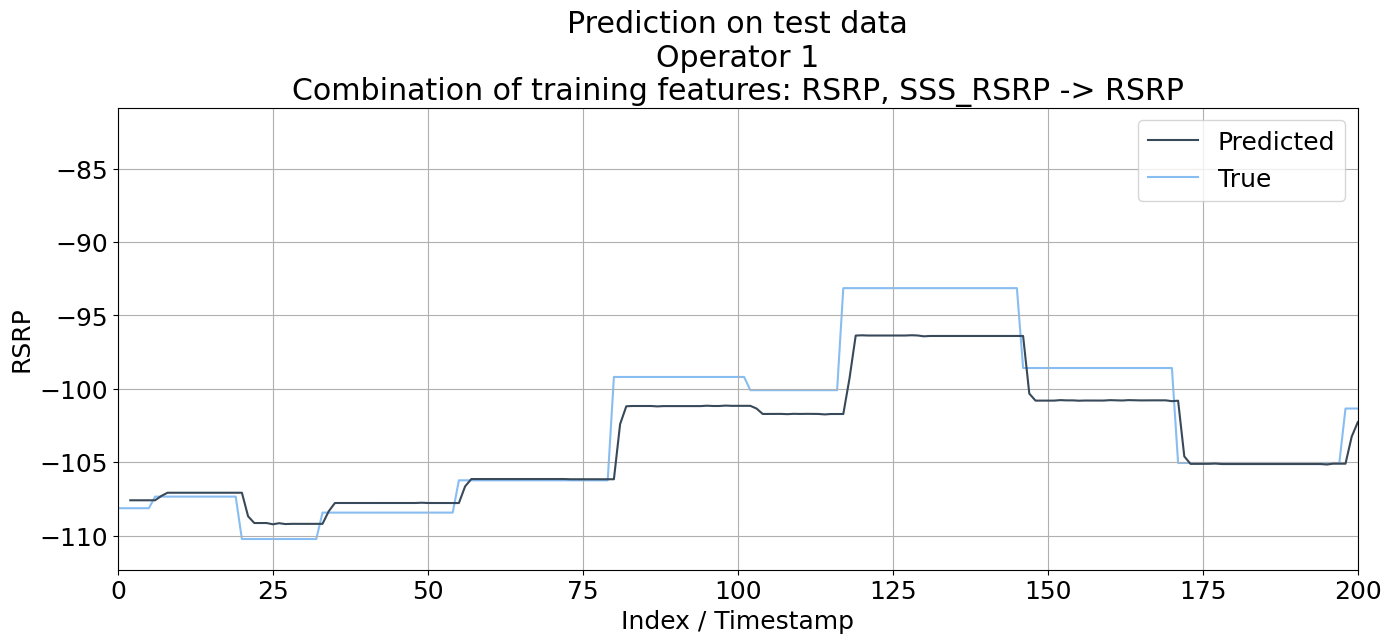

In [121]:
selected_rsrp_comb = 'RSRP, SSS_RSRP -> RSRP'
rsrp_comb = op1_lstm_results[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred_plot']
rsrp_true = rsrp_comb['y_true_plot']
rsrp_train_pred = rsrp_comb['train_pred_plot']
rsrp_train_true = rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrp_pred, true=rsrp_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='test')

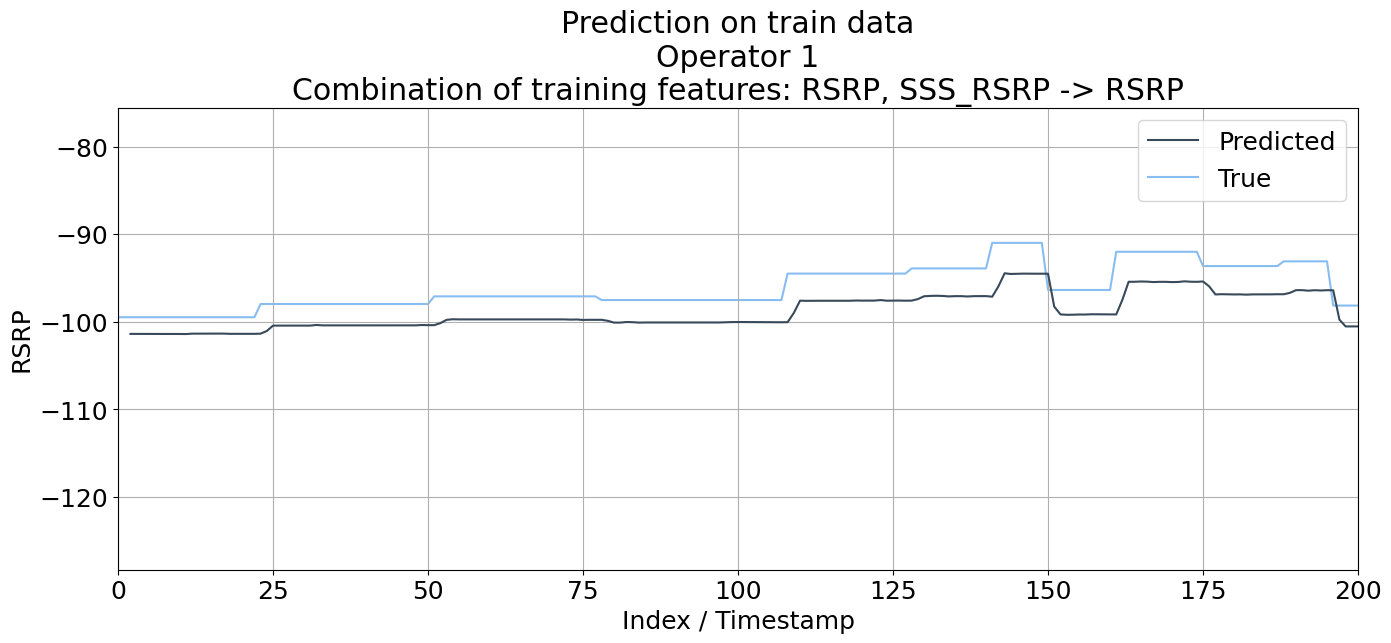

In [122]:
fig = plot_lstm_1_step(pred=rsrp_train_pred, true=rsrp_train_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='train')

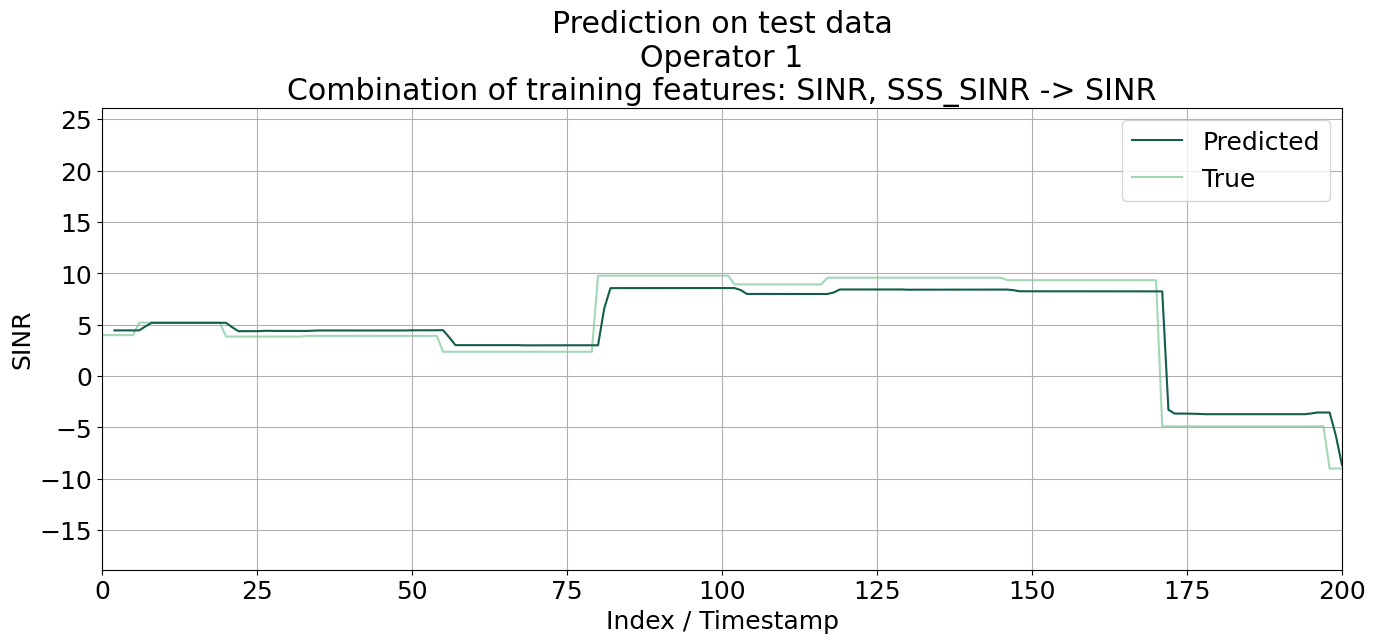

In [123]:
selected_sinr_comb = 'SINR, SSS_SINR -> SINR'
sinr_comb = op1_lstm_results[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred_plot']
sinr_true = sinr_comb['y_true_plot']
sinr_train_pred = sinr_comb['train_pred_plot']
sinr_train_true = sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sinr_pred, true=sinr_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='test')

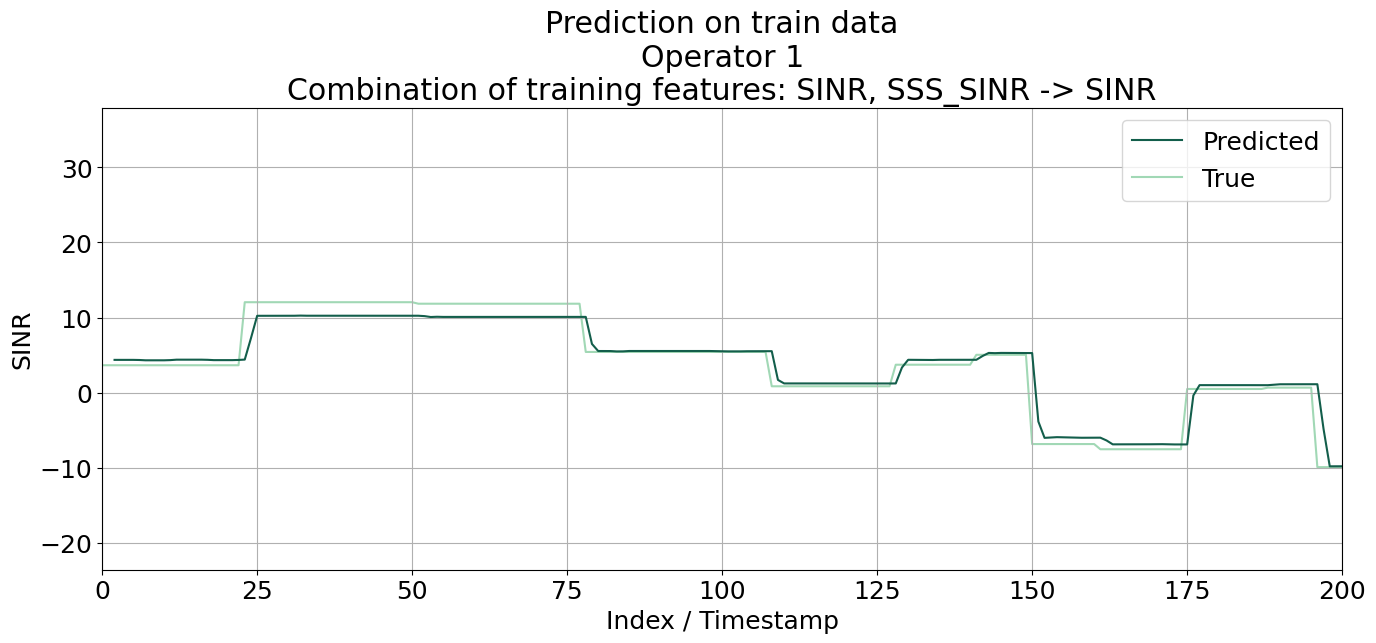

In [124]:
fig = plot_lstm_1_step(pred=sinr_train_pred, true=sinr_train_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='train')

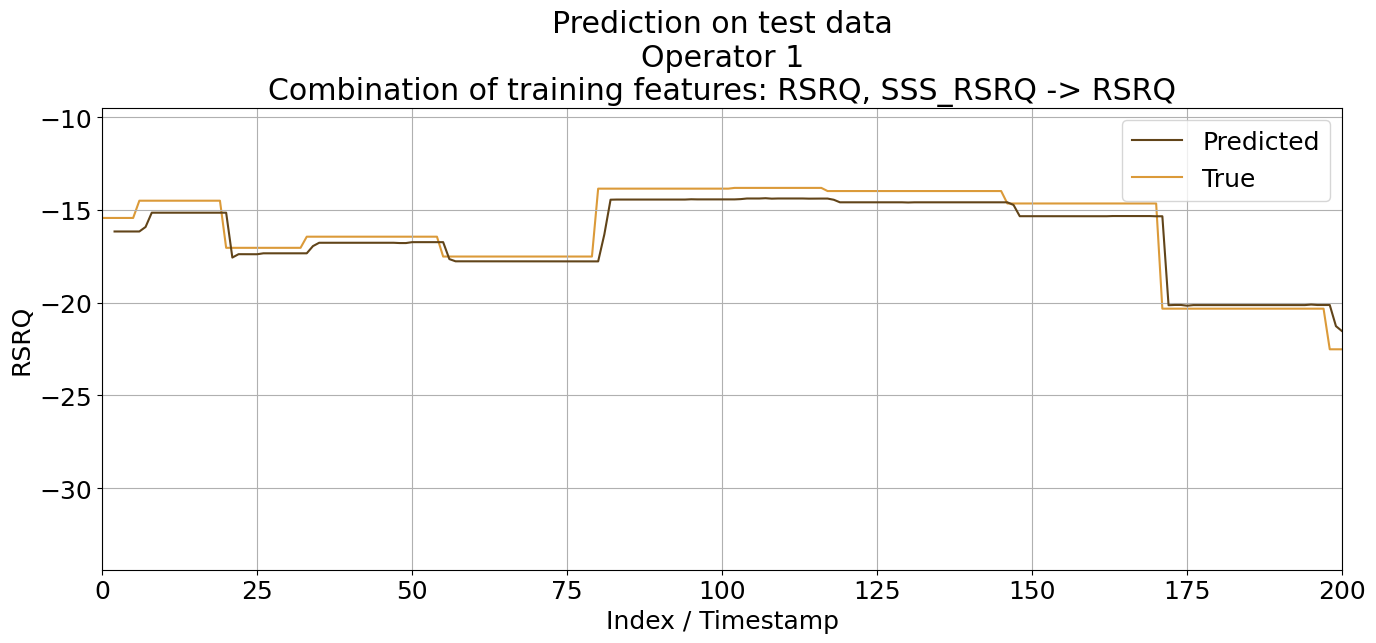

In [125]:
selected_rsrq_comb = 'RSRQ, SSS_RSRQ -> RSRQ'
rsrq_comb = op1_lstm_results[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred_plot']
rsrq_true = rsrq_comb['y_true_plot']
rsrq_train_pred = rsrq_comb['train_pred_plot']
rsrq_train_true = rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrq_pred, true=rsrq_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='test')

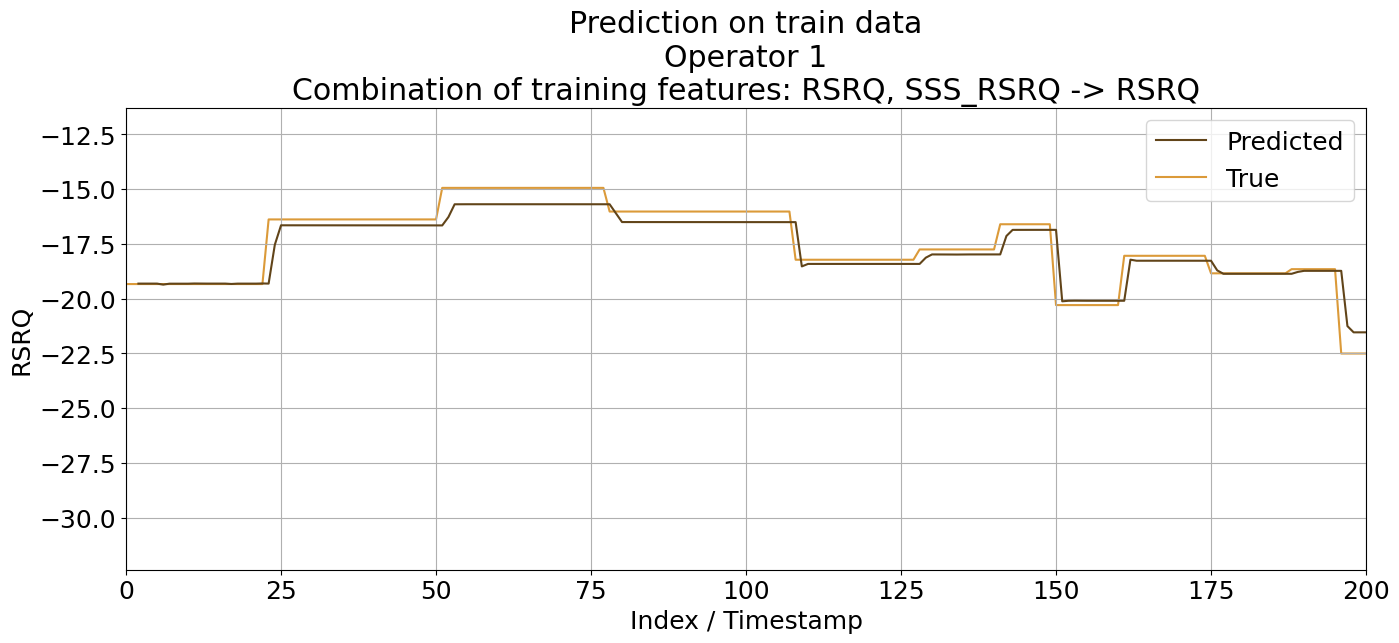

In [126]:
fig = plot_lstm_1_step(pred=rsrq_train_pred, true=rsrq_train_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='train')

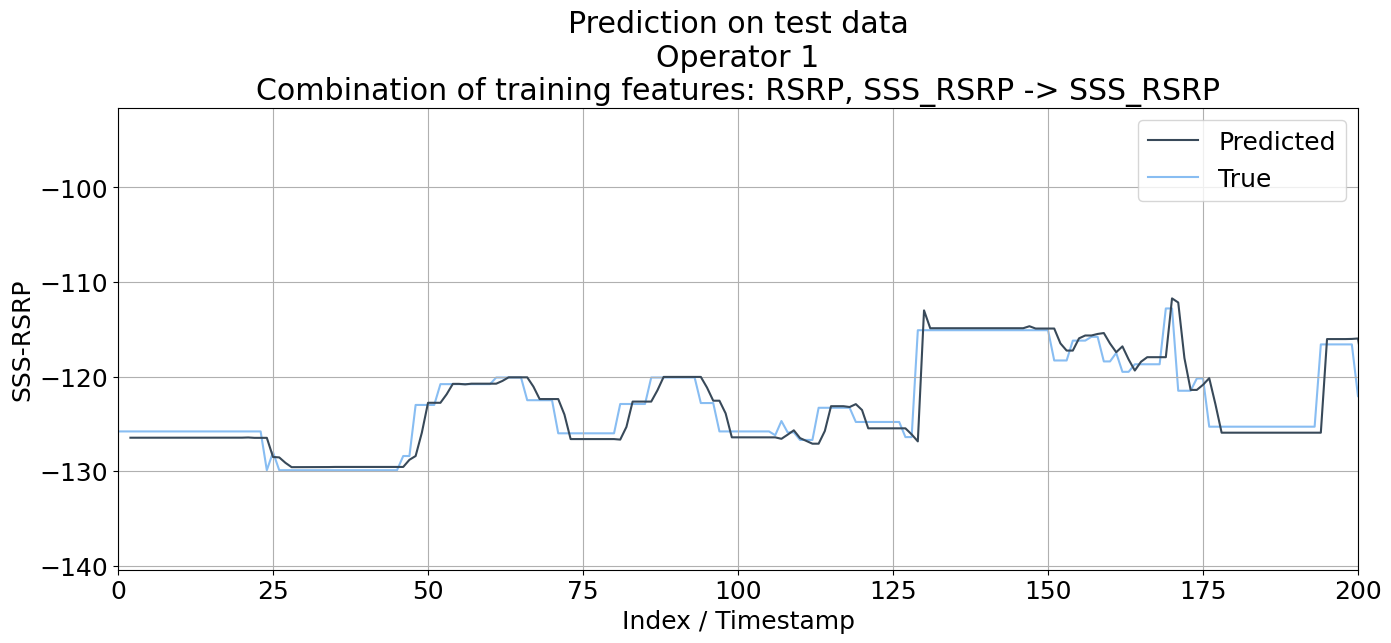

In [127]:
selected_sss_rsrp_comb = 'RSRP, SSS_RSRP -> SSS_RSRP'
sss_rsrp_comb = op1_lstm_results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred_plot']
sss_rsrp_true = sss_rsrp_comb['y_true_plot']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred_plot']
sss_rsrp_train_true = sss_rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrp_pred, true=sss_rsrp_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='test')

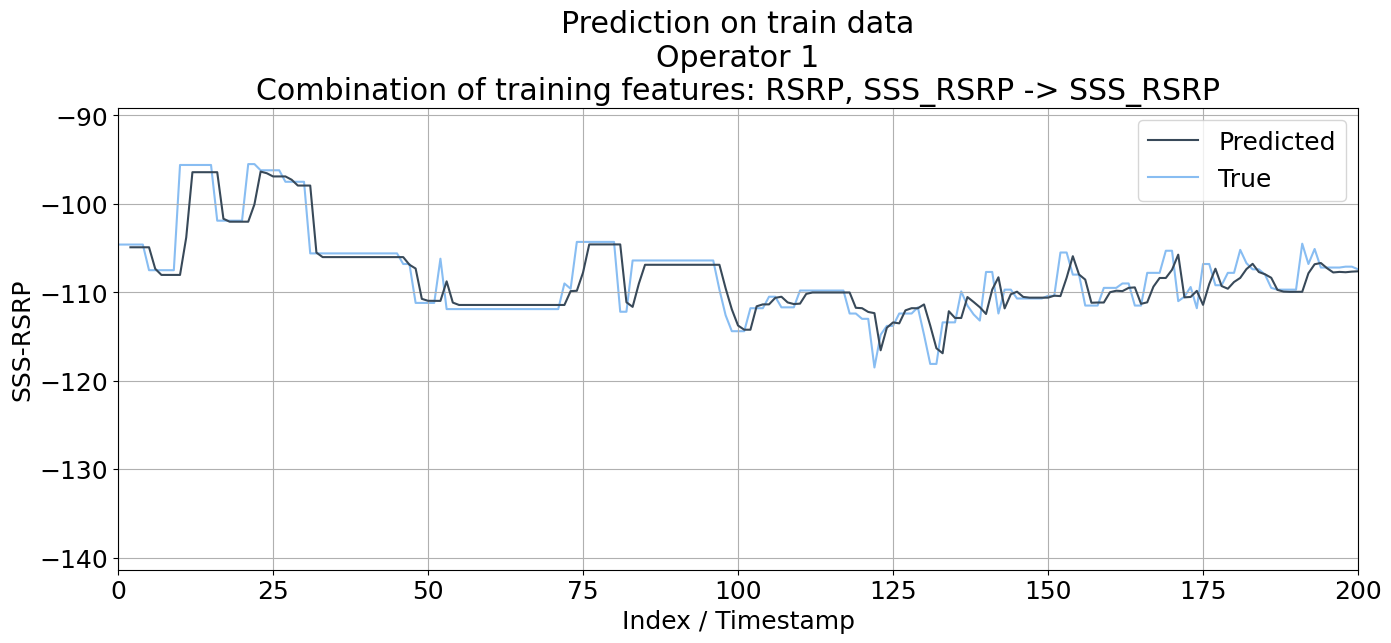

In [128]:
fig = plot_lstm_1_step(pred=sss_rsrp_train_pred, true=sss_rsrp_train_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='train')

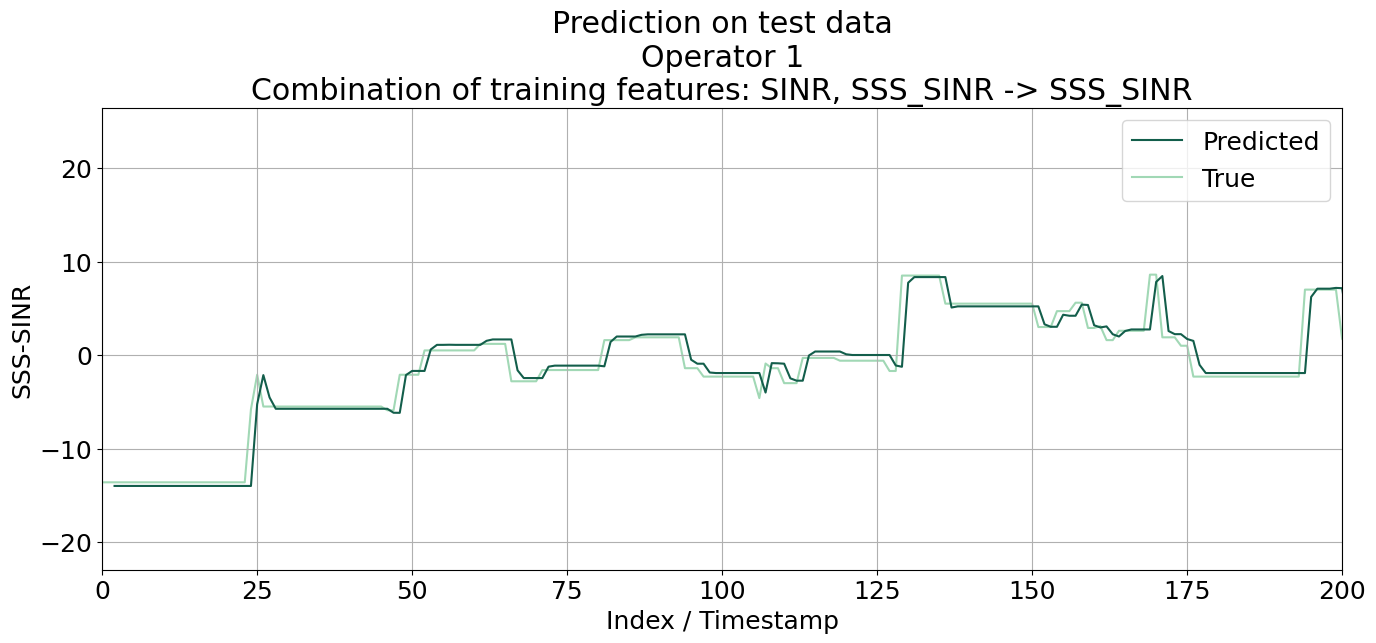

In [129]:
selected_sss_sinr_comb = 'SINR, SSS_SINR -> SSS_SINR'
sss_sinr_comb = op1_lstm_results[selected_sss_sinr_comb]
sss_sinr_pred = sss_sinr_comb['y_pred_plot']
sss_sinr_true = sss_sinr_comb['y_true_plot']
sss_sinr_train_pred = sss_sinr_comb['train_pred_plot']
sss_sinr_train_true = sss_sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_sinr_pred, true=sss_sinr_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='test')

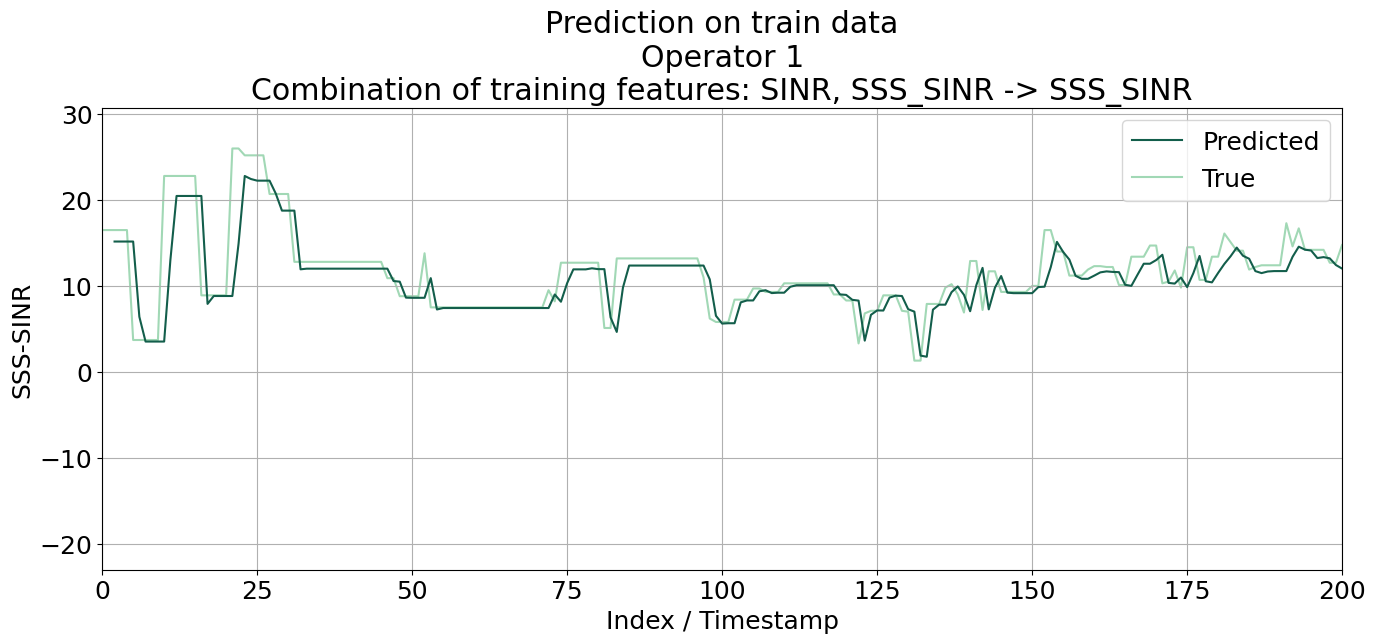

In [130]:
fig = plot_lstm_1_step(pred=sss_sinr_train_pred, true=sss_sinr_train_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='train')

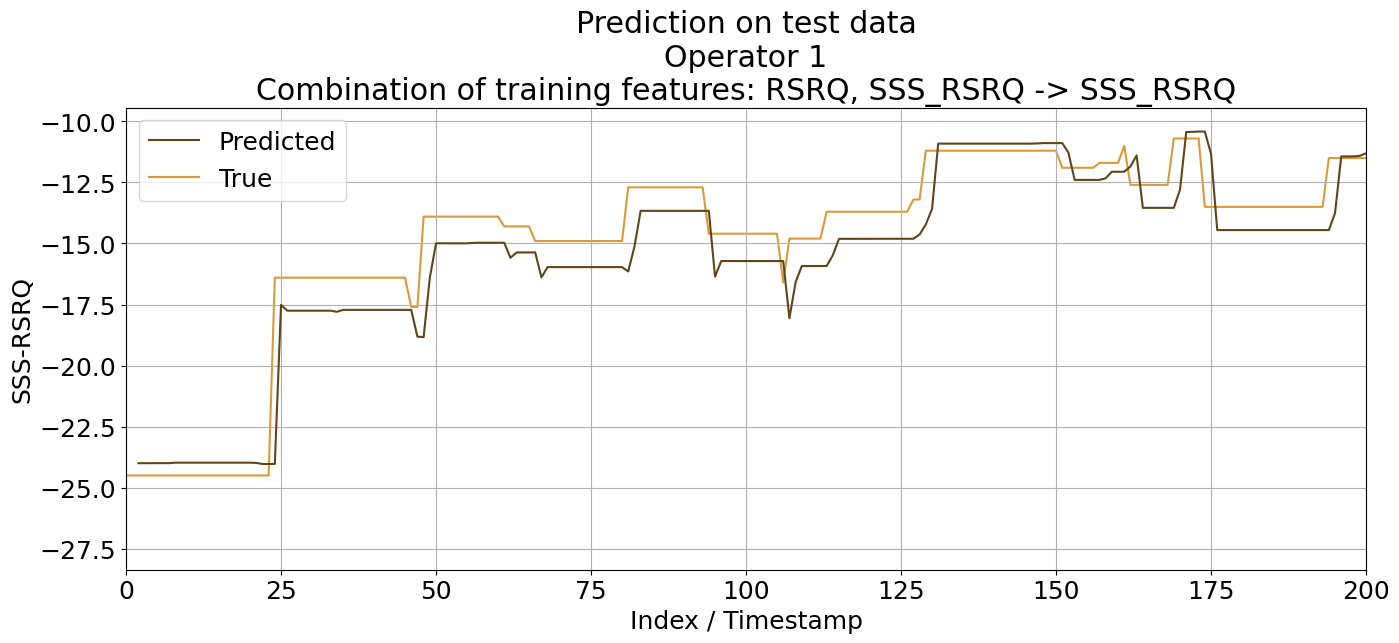

In [131]:
selected_sss_rsrq_comb = 'RSRQ, SSS_RSRQ -> SSS_RSRQ'
sss_rsrq_comb = op1_lstm_results[selected_sss_rsrq_comb]
sss_rsrq_pred = sss_rsrq_comb['y_pred_plot']
sss_rsrq_true = sss_rsrq_comb['y_true_plot']
sss_rsrq_train_pred = sss_rsrq_comb['train_pred_plot']
sss_rsrq_train_true = sss_rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrq_pred, true=sss_rsrq_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

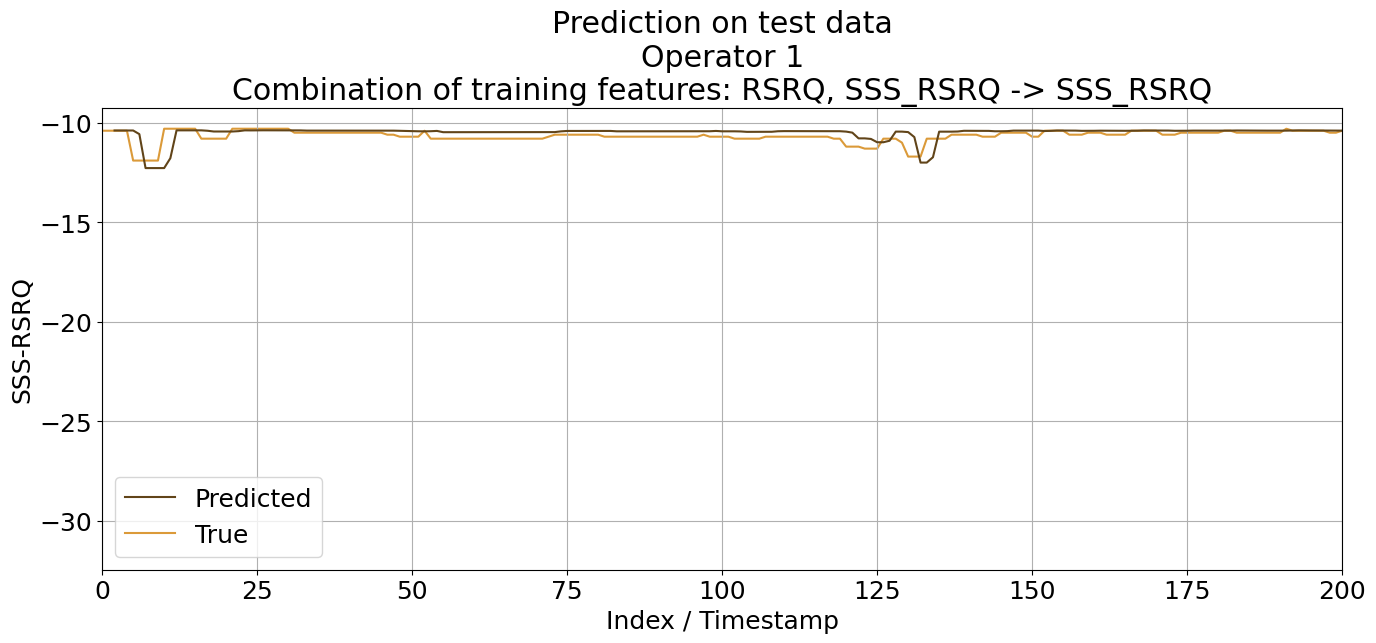

In [132]:
fig = plot_lstm_1_step(pred=sss_rsrq_train_pred, true=sss_rsrq_train_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

In [133]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

op1_lstm_preds = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': op1_lstm_results[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': op1_lstm_results[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['y_pred'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

op1_lstm_pred_train = pd.DataFrame({'RSRP': op1_lstm_results[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': op1_lstm_results[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': op1_lstm_results[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': op1_lstm_results[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': op1_lstm_results[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': op1_lstm_results[sss_feature_comb[2]]['train_pred'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'])

## Random Forest

In [134]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [146]:
rf_results = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.append('campaign')
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=op1_lstm_preds, train_preds__=op1_lstm_pred_train, n_steps_in=2, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 5, min_leaf: 1",0.648,0.698,0.388,0.998,0.992,0.997,0.649,0.385,0.703,0.881,0.891,0.683
1,"n_est: 5, min_leaf: 5",0.626,0.706,0.294,0.992,0.975,0.990,0.625,0.335,0.670,0.888,0.863,0.707
2,"n_est: 5, min_leaf: 10",0.651,0.726,0.364,0.986,0.953,0.987,0.663,0.448,0.696,0.874,0.893,0.667
3,"n_est: 5, min_leaf: 15",0.647,0.740,0.335,0.976,0.918,0.980,0.653,0.415,0.695,0.869,0.901,0.654
4,"n_est: 10, min_leaf: 1",0.619,0.679,0.296,0.998,0.993,0.996,0.639,0.358,0.694,0.897,0.875,0.728
5,"n_est: 10, min_leaf: 5",0.641,0.707,0.348,0.993,0.976,0.994,0.649,0.403,0.691,0.894,0.866,0.723
6,"n_est: 10, min_leaf: 10",0.641,0.720,0.337,0.988,0.958,0.993,0.638,0.379,0.676,0.871,0.892,0.660
7,"n_est: 10, min_leaf: 15",0.654,0.707,0.400,0.982,0.938,0.986,0.667,0.455,0.703,0.885,0.912,0.686
8,"n_est: 50, min_leaf: 1",0.653,0.741,0.356,0.998,0.994,0.997,0.643,0.388,0.683,0.897,0.902,0.718
9,"n_est: 50, min_leaf: 5",0.655,0.754,0.352,0.996,0.986,0.995,0.653,0.402,0.703,0.886,0.904,0.690


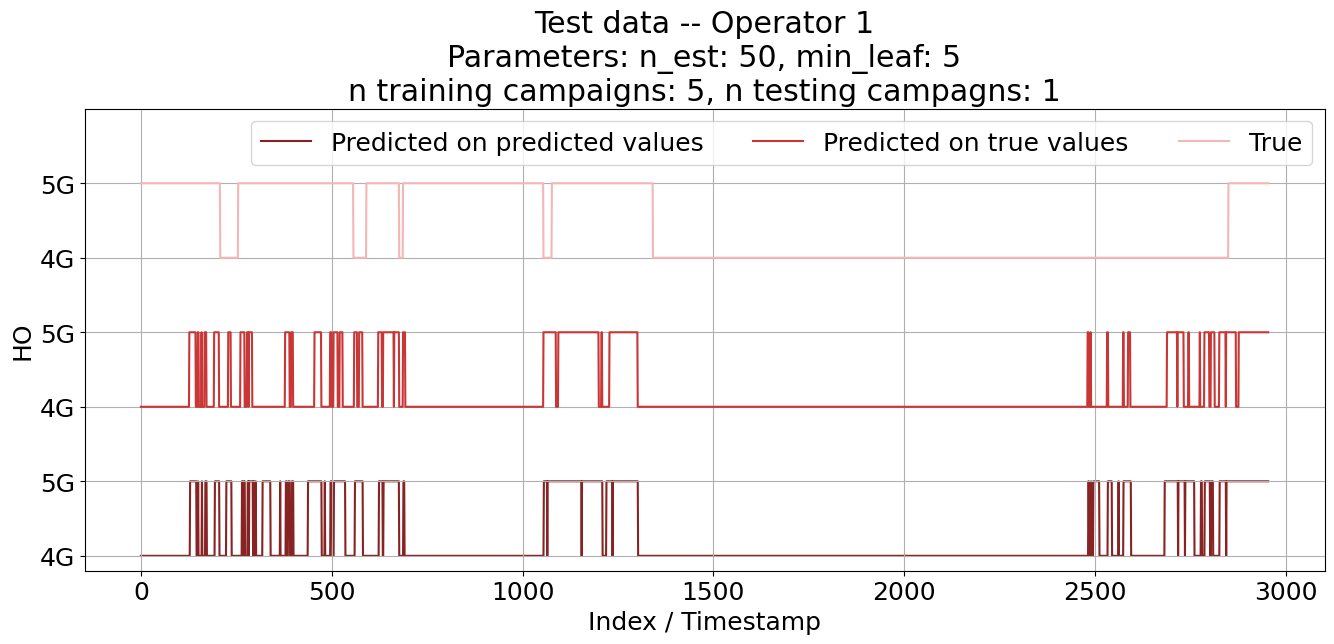

In [185]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

In [237]:
op1_preds = op1_lstm_preds.copy()
op1_preds['Mode'] = y_true
op1_preds['Mode_pred'] = y_pred
op1_preds['Mode_pred_pred'] = pred_pred
plt.rcParams.update({'font.size': 20})

In [238]:
true_4G = test[test['Mode'] == 0]
true_5G = test[test['Mode'] == 1]

rsrp_pred_4G, rsrp_pred_5G = [], []
rsrp_pred_4g_ho, rsrp_pred_5g_ho = [], []
for i in range(len(op1_preds)):
    if op1_preds.iloc[i]['Mode_pred'] == 0:
        rsrp_pred_4G.append([test.iloc[i + n_steps_in]['RSRP'], test.iloc[i + n_steps_in]['SSS_RSRP']])
        if i < len(op1_preds) - 1:
            if op1_preds.iloc[i+1]['Mode_pred'] == 1:
                rsrp_pred_5g_ho.append((test.iloc[i + n_steps_in + 1]['SSS_RSRP'], test.iloc[i + n_steps_in + 1]['RSRP']))
    if op1_preds.iloc[i]['Mode_pred'] == 1:
        rsrp_pred_5G.append([test.iloc[i + n_steps_in]['RSRP'], test.iloc[i + n_steps_in]['SSS_RSRP']])
        if i < len(op1_preds) - 1:
            if op1_preds.iloc[i+1]['Mode_pred'] == 0:
                rsrp_pred_4g_ho.append((test.iloc[i + n_steps_in + 1]['SSS_RSRP'], test.iloc[i + n_steps_in + 1]['RSRP']))

pred_pred_4G = op1_preds[op1_preds['Mode_pred_pred'] == 0]
pred_pred_5G = op1_preds[op1_preds['Mode_pred_pred'] == 1]

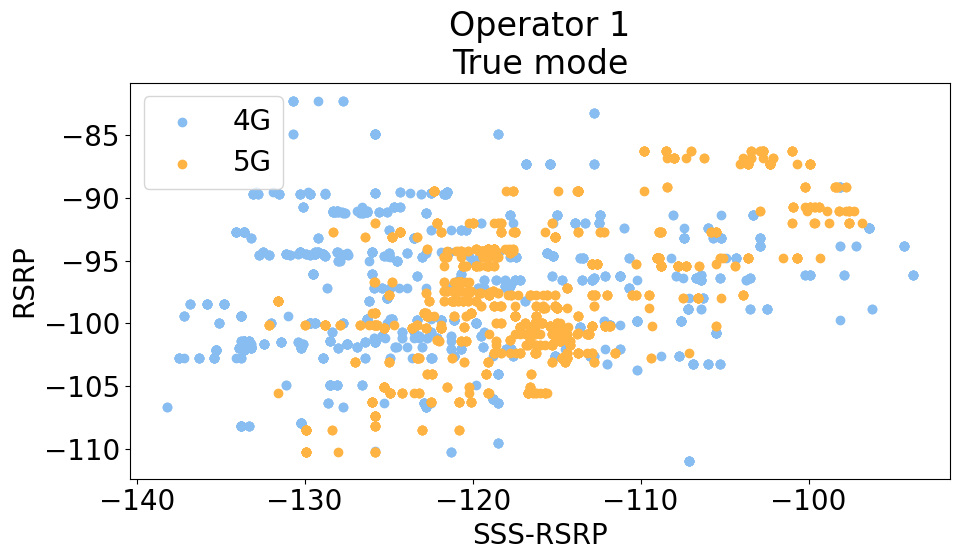

In [239]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(true_4G['SSS_RSRP'], true_4G['RSRP'], color=rsrp_colors[2], label='4G')
plt.scatter(true_5G['SSS_RSRP'], true_5G['RSRP'], color=rsrq_colors[3], label='5G')
plt.title(f'{operator}\nTrue mode')
plt.xlabel('SSS-RSRP')
plt.ylabel('RSRP')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrp_true_mode.pdf')

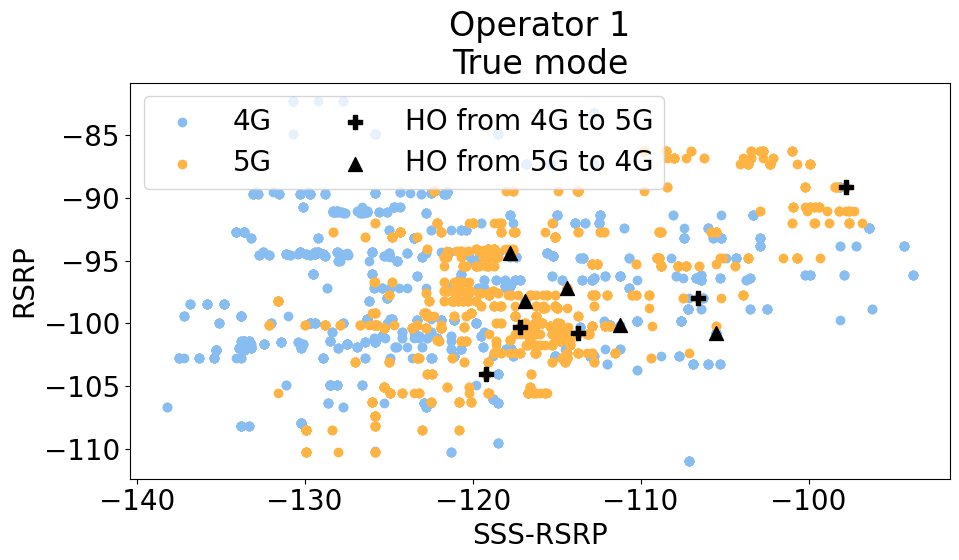

In [240]:
rsrp_ho_to_4g, sss_rsrp_ho_to_4g = [], []
rsrp_ho_to_5g, sss_rsrp_ho_to_5g = [], []

for i in range(len(test) - 1):
    if test['Mode'].iloc[i] == 0 and test['Mode'].iloc[i+1] == 1:
        rsrp_ho_to_5g.append(test['RSRP'].iloc[i+1])
        sss_rsrp_ho_to_5g.append(test['SSS_RSRP'].iloc[i+1])
    elif test['Mode'].iloc[i] == 1 and test['Mode'].iloc[i+1] == 0:
        rsrp_ho_to_4g.append(test['RSRP'].iloc[i+1])
        sss_rsrp_ho_to_4g.append(test['SSS_RSRP'].iloc[i+1])


fig, ax = plt.subplots(figsize=(10, 6))
g4 = plt.scatter(true_4G['SSS_RSRP'], true_4G['RSRP'], color=rsrp_colors[2], label='4G')
g5 = plt.scatter(true_5G['SSS_RSRP'], true_5G['RSRP'], color=rsrq_colors[3], label='5G')

ho_4g_to_5g = plt.scatter(sss_rsrp_ho_to_5g, rsrp_ho_to_5g, marker='P', color='black', label='HO from 4G to 5G', s=100)
ho_5g_to_4g = plt.scatter(sss_rsrp_ho_to_4g, rsrp_ho_to_4g, marker='^', color='black', label='HO from 5G to 4G', s=100)

plt.title(f'{operator}\nTrue mode')
plt.xlabel('SSS-RSRP')
plt.ylabel('RSRP')
plt.legend(handles=[g4, g5, ho_4g_to_5g, ho_5g_to_4g], ncols = 2)
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrp_true_mode_with_ho.pdf')

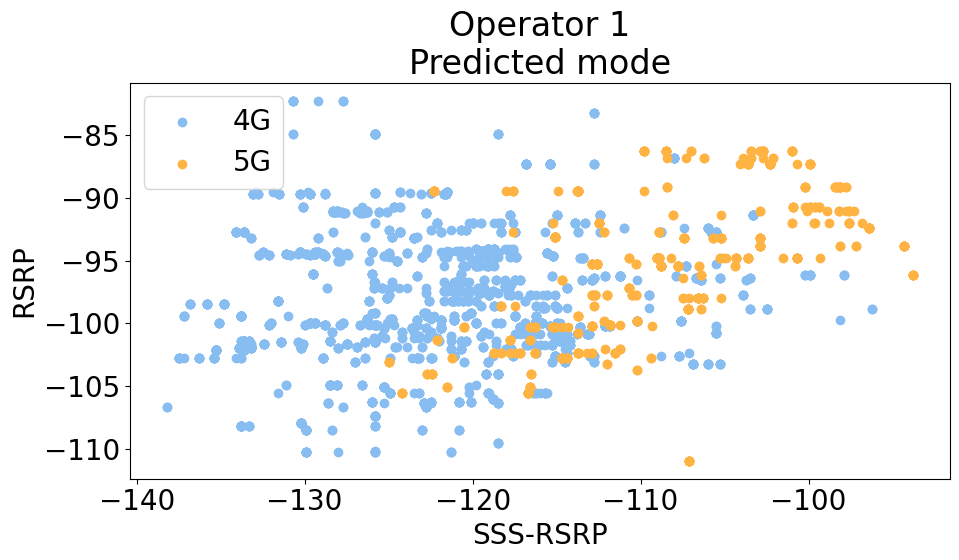

In [241]:
fig = plt.figure(figsize=(10, 6))
plt.scatter([x[1] for x in rsrp_pred_4G], [x[0] for x in rsrp_pred_4G], color=rsrp_colors[2], label='4G')
plt.scatter([x[1] for x in rsrp_pred_5G], [x[0] for x in rsrp_pred_5G], color=rsrq_colors[3], label='5G')
plt.title(f'{operator}\nPredicted mode')
plt.xlabel('SSS-RSRP')
plt.ylabel('RSRP')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrp_predicted_mode.pdf')

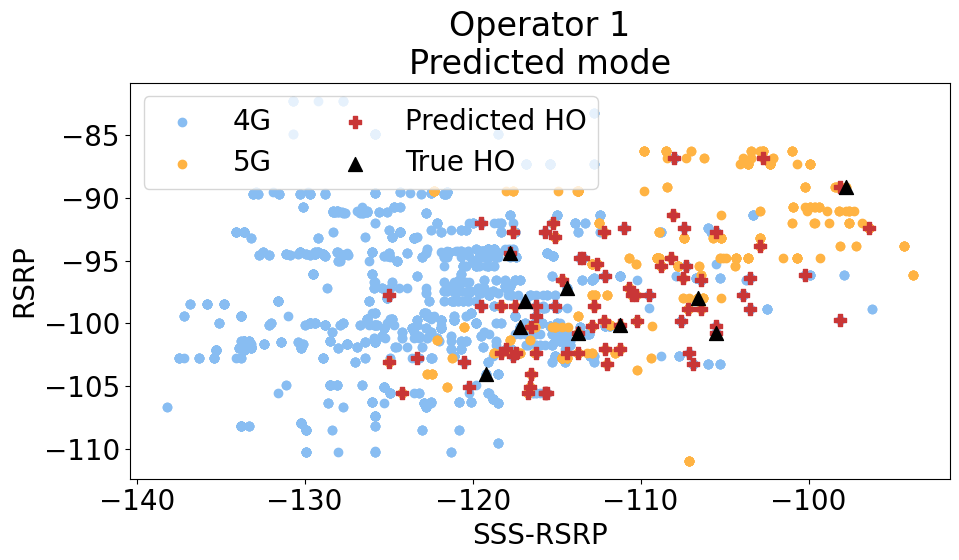

In [242]:
fig, ax = plt.subplots(figsize=(10, 6))
g4 = ax.scatter([x[1] for x in rsrp_pred_4G], [x[0] for x in rsrp_pred_4G], color=rsrp_colors[2], label='4G')
g5 = ax.scatter([x[1] for x in rsrp_pred_5G], [x[0] for x in rsrp_pred_5G], color=rsrq_colors[3], label='5G')
ho_pred = ax.scatter([x[0] for x in rsrp_pred_5g_ho], [x[1] for x in rsrp_pred_5g_ho], marker='P', color=mode_colors[1], s=80, label='Predicted HO')
ax.scatter([x[0] for x in rsrp_pred_4g_ho], [x[1] for x in rsrp_pred_4g_ho], marker='P', color=mode_colors[1], s=80, label='Predicted HO')
ho_true = ax.scatter(sss_rsrp_ho_to_5g, rsrp_ho_to_5g, marker='^', color='black', label='True HO', s=100)
ax.scatter(sss_rsrp_ho_to_4g, rsrp_ho_to_4g, marker='^', color='black', label='True HO', s=100)
plt.title(f'{operator}\nPredicted mode')
plt.xlabel('SSS-RSRP')
plt.ylabel('RSRP')
plt.legend(handles=[g4, g5, ho_pred, ho_true], ncols = 2)
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrp_predicted_mode_with_ho.pdf')

In [243]:
# fig = plt.figure(figsize=(10, 6))
# plt.scatter([x[0] for x in pred_pred_4G['SSS_RSRP']], [x[0] for x in pred_pred_4G['RSRP']], color=rsrp_colors[2], label='4G')
# plt.scatter([x[0] for x in pred_pred_5G['SSS_RSRP']], [x[0] for x in pred_pred_5G['RSRP']], color=rsrq_colors[3], label='5G')
# plt.title(f'{operator}\nPredicted mode, predicted values')
# plt.xlabel('SSS-RSRP')
# plt.ylabel('RSRP')
# plt.legend()
# plt.tight_layout()
# plt.show()
# fig.savefig(r'../latex/plots/thresholds/op1_predicted_mode_predicted_values.pdf')

In [244]:
sinr_pred_4G, sinr_pred_5G = [], []
sinr_pred_4g_ho, sinr_pred_5g_ho = [], []
for i in range(len(op1_preds)):
    if op1_preds.iloc[i]['Mode_pred'] == 0:
        sinr_pred_4G.append([test.iloc[i + n_steps_in]['SINR'], test.iloc[i + n_steps_in]['SSS_SINR']])
        if i < len(op1_preds) - 1:
            if op1_preds.iloc[i+1]['Mode_pred'] == 1:
                sinr_pred_5g_ho.append((test.iloc[i + n_steps_in + 1]['SSS_SINR'], test.iloc[i + n_steps_in + 1]['SINR']))
    if op1_preds.iloc[i]['Mode_pred'] == 1:
        sinr_pred_5G.append([test.iloc[i + n_steps_in]['SINR'], test.iloc[i + n_steps_in]['SSS_SINR']])
        if i < len(op1_preds) - 1:
            if op1_preds.iloc[i+1]['Mode_pred'] == 0:
                sinr_pred_4g_ho.append((test.iloc[i + n_steps_in + 1]['SSS_SINR'], test.iloc[i + n_steps_in + 1]['SINR']))

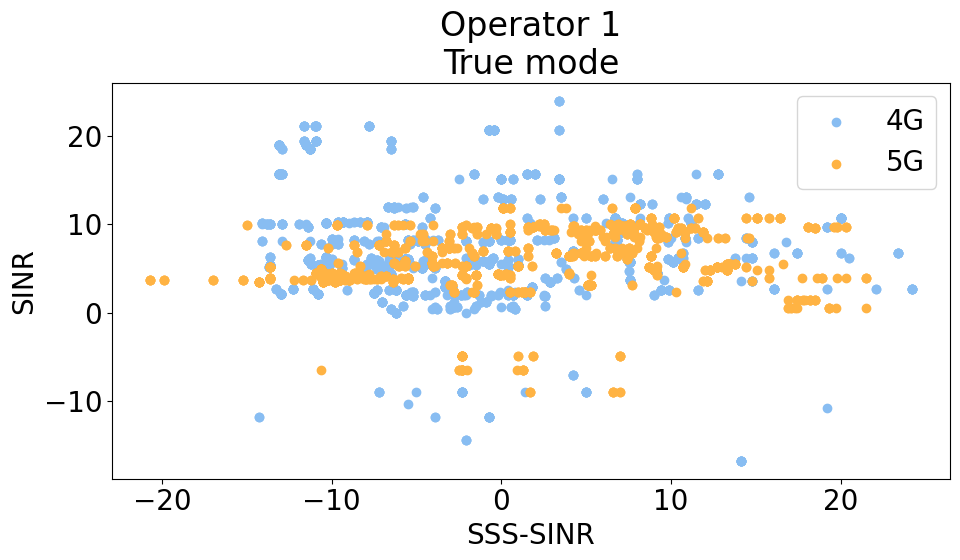

In [245]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(true_4G['SSS_SINR'], true_4G['SINR'], color=rsrp_colors[2], label='4G')
plt.scatter(true_5G['SSS_SINR'], true_5G['SINR'], color=rsrq_colors[3], label='5G')
plt.title(f'{operator}\nTrue mode')
plt.xlabel('SSS-SINR')
plt.ylabel('SINR')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_sinr_true_mode.pdf')

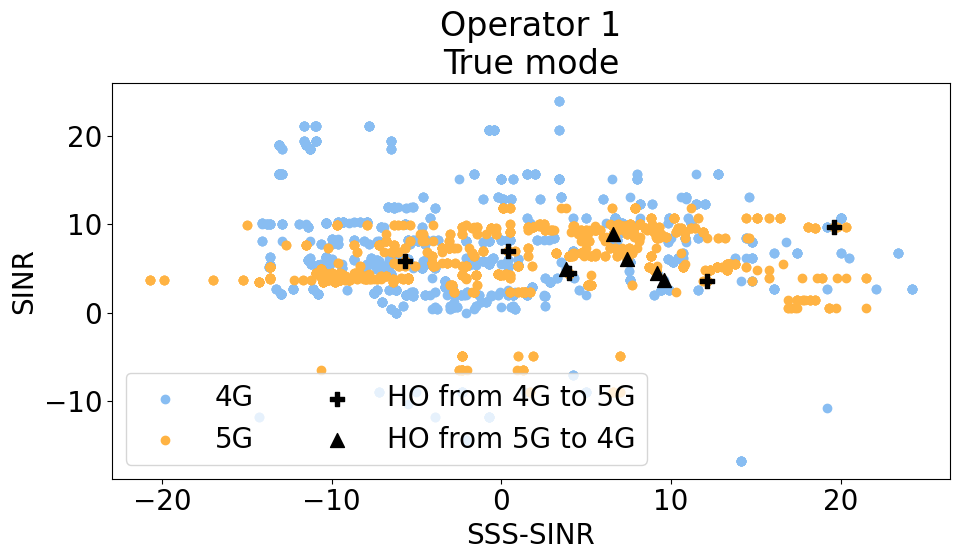

In [246]:
sinr_ho_to_4g, sss_sinr_ho_to_4g = [], []
sinr_ho_to_5g, sss_sinr_ho_to_5g = [], []

for i in range(len(test) - 1):
    if test['Mode'].iloc[i] == 0 and test['Mode'].iloc[i+1] == 1:
        sinr_ho_to_5g.append(test['SINR'].iloc[i+1])
        sss_sinr_ho_to_5g.append(test['SSS_SINR'].iloc[i+1])
    elif test['Mode'].iloc[i] == 1 and test['Mode'].iloc[i+1] == 0:
        sinr_ho_to_4g.append(test['SINR'].iloc[i+1])
        sss_sinr_ho_to_4g.append(test['SSS_SINR'].iloc[i+1])


fig, ax = plt.subplots(figsize=(10, 6))
g4 = plt.scatter(true_4G['SSS_SINR'], true_4G['SINR'], color=rsrp_colors[2], label='4G')
g5 = plt.scatter(true_5G['SSS_SINR'], true_5G['SINR'], color=rsrq_colors[3], label='5G')

ho_4g_to_5g = plt.scatter(sss_sinr_ho_to_5g, sinr_ho_to_5g, marker='P', color='black', label='HO from 4G to 5G', s=100)
ho_5g_to_4g = plt.scatter(sss_sinr_ho_to_4g, sinr_ho_to_4g, marker='^', color='black', label='HO from 5G to 4G', s=100)
plt.title(f'{operator}\nTrue mode')
plt.xlabel('SSS-SINR')
plt.ylabel('SINR')
plt.legend(handles=[g4, g5, ho_4g_to_5g, ho_5g_to_4g], ncols = 2)
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_sinr_true_mode_with_ho.pdf')

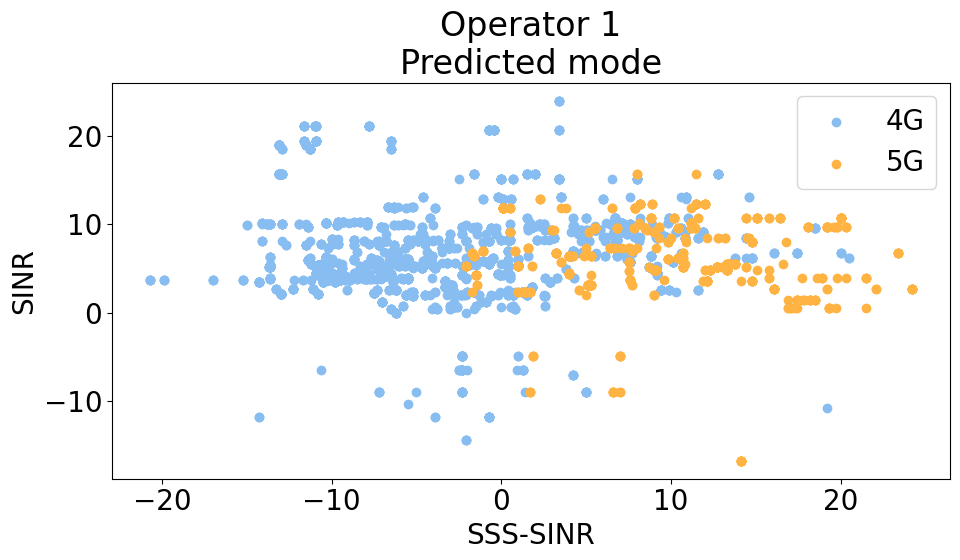

In [247]:
fig = plt.figure(figsize=(10, 6))
plt.scatter([x[1] for x in sinr_pred_4G], [x[0] for x in sinr_pred_4G], color=rsrp_colors[2], label='4G')
plt.scatter([x[1] for x in sinr_pred_5G], [x[0] for x in sinr_pred_5G], color=rsrq_colors[3], label='5G')
plt.title(f'{operator}\nPredicted mode')
plt.xlabel('SSS-SINR')
plt.ylabel('SINR')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_sinr_predicted_mode.pdf')

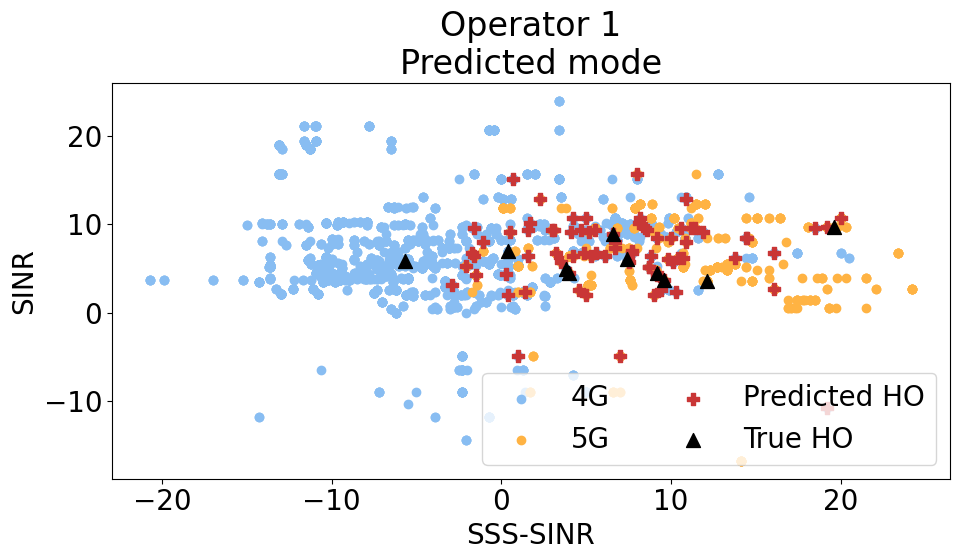

In [248]:
fig, ax = plt.subplots(figsize=(10, 6))
g4 = ax.scatter([x[1] for x in sinr_pred_4G], [x[0] for x in sinr_pred_4G], color=rsrp_colors[2], label='4G')
g5 = ax.scatter([x[1] for x in sinr_pred_5G], [x[0] for x in sinr_pred_5G], color=rsrq_colors[3], label='5G')
ho_pred = ax.scatter([x[0] for x in sinr_pred_5g_ho], [x[1] for x in sinr_pred_5g_ho], marker='P', color=mode_colors[1], s=80, label='Predicted HO')
ax.scatter([x[0] for x in sinr_pred_4g_ho], [x[1] for x in sinr_pred_4g_ho], marker='P', color=mode_colors[1], s=80, label='Predicted HO')
ho_true = ax.scatter(sss_sinr_ho_to_5g, sinr_ho_to_5g, marker='^', color='black', label='True HO', s=100)
ax.scatter(sss_sinr_ho_to_4g, sinr_ho_to_4g, marker='^', color='black', label='True HO', s=100)
plt.title(f'{operator}\nPredicted mode')
plt.xlabel('SSS-SINR')
plt.ylabel('SINR')
plt.legend(handles=[g4, g5, ho_pred, ho_true], ncols = 2)
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_sinr_predicted_mode_with_ho.pdf')

In [249]:
rsrq_pred_4G, rsrq_pred_5G = [], []
rsrq_pred_4g_ho, rsrq_pred_5g_ho = [], []
for i in range(len(op1_preds)):
    if op1_preds.iloc[i]['Mode_pred'] == 0:
        rsrq_pred_4G.append([test.iloc[i + n_steps_in]['RSRQ'], test.iloc[i + n_steps_in]['SSS_RSRQ']])
        if i < len(op1_preds) - 1:
            if op1_preds.iloc[i+1]['Mode_pred'] == 1:
                rsrq_pred_5g_ho.append((test.iloc[i + n_steps_in + 1]['SSS_RSRQ'], test.iloc[i + n_steps_in + 1]['RSRQ']))
    if op1_preds.iloc[i]['Mode_pred'] == 1:
        rsrq_pred_5G.append([test.iloc[i + n_steps_in]['RSRQ'], test.iloc[i + n_steps_in]['SSS_RSRQ']])
        if i < len(op1_preds) - 1:
            if op1_preds.iloc[i+1]['Mode_pred'] == 0:
                rsrq_pred_4g_ho.append((test.iloc[i + n_steps_in + 1]['SSS_RSRQ'], test.iloc[i + n_steps_in + 1]['RSRQ']))

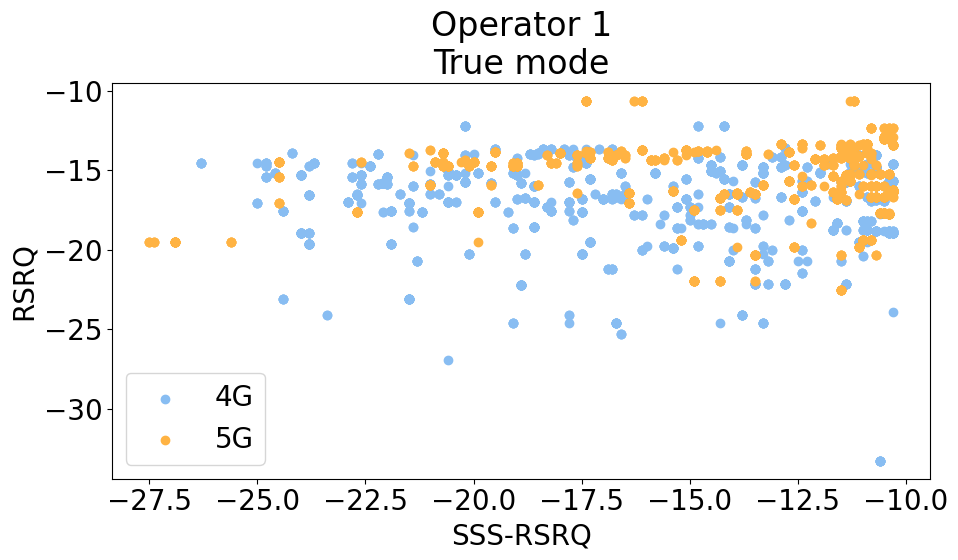

In [250]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(true_4G['SSS_RSRQ'], true_4G['RSRQ'], color=rsrp_colors[2], label='4G')
plt.scatter(true_5G['SSS_RSRQ'], true_5G['RSRQ'], color=rsrq_colors[3], label='5G')
plt.title(f'{operator}\nTrue mode')
plt.xlabel('SSS-RSRQ')
plt.ylabel('RSRQ')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrq_true_mode.pdf')

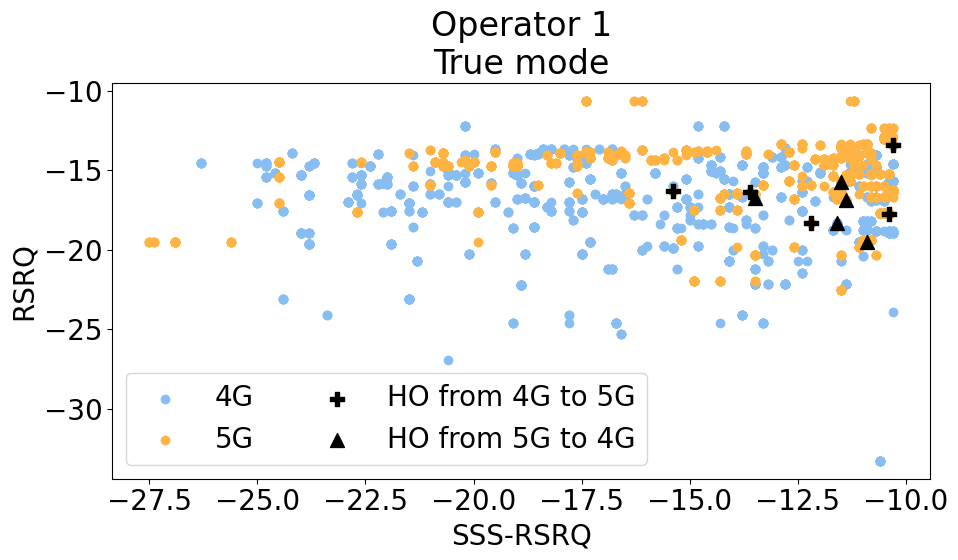

In [251]:
rsrq_ho_to_4g, sss_rsrq_ho_to_4g = [], []
rsrq_ho_to_5g, sss_rsrq_ho_to_5g = [], []

for i in range(len(test) - 1):
    if test['Mode'].iloc[i] == 0 and test['Mode'].iloc[i+1] == 1:
        rsrq_ho_to_5g.append(test['RSRQ'].iloc[i+1])
        sss_rsrq_ho_to_5g.append(test['SSS_RSRQ'].iloc[i+1])
    elif test['Mode'].iloc[i] == 1 and test['Mode'].iloc[i+1] == 0:
        rsrq_ho_to_4g.append(test['RSRQ'].iloc[i+1])
        sss_rsrq_ho_to_4g.append(test['SSS_RSRQ'].iloc[i+1])


fig, ax = plt.subplots(figsize=(10, 6))
g4 = plt.scatter(true_4G['SSS_RSRQ'], true_4G['RSRQ'], color=rsrp_colors[2], label='4G')
g5 = plt.scatter(true_5G['SSS_RSRQ'], true_5G['RSRQ'], color=rsrq_colors[3], label='5G')

ho_4g_to_5g = plt.scatter(sss_rsrq_ho_to_5g, rsrq_ho_to_5g, marker='P', color='black', label='HO from 4G to 5G', s=100)
ho_5g_to_4g = plt.scatter(sss_rsrq_ho_to_4g, rsrq_ho_to_4g, marker='^', color='black', label='HO from 5G to 4G', s=100)
plt.title(f'{operator}\nTrue mode')
plt.xlabel('SSS-RSRQ')
plt.ylabel('RSRQ')
plt.legend(handles=[g4, g5, ho_4g_to_5g, ho_5g_to_4g], ncols = 2)
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrq_true_mode_with_ho.pdf')

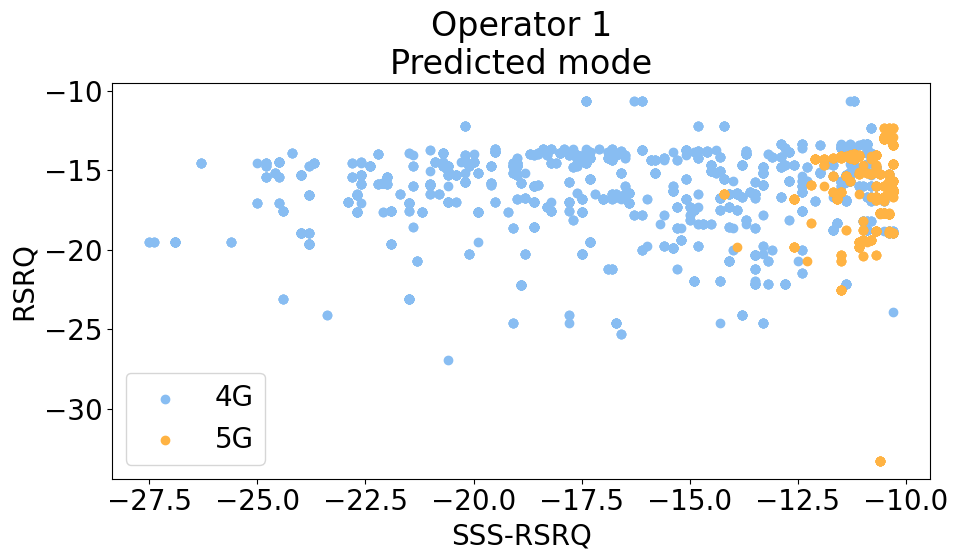

In [252]:
fig = plt.figure(figsize=(10, 6))
plt.scatter([x[1] for x in rsrq_pred_4G], [x[0] for x in rsrq_pred_4G], color=rsrp_colors[2], label='4G')
plt.scatter([x[1] for x in rsrq_pred_5G], [x[0] for x in rsrq_pred_5G], color=rsrq_colors[3], label='5G')
plt.title(f'{operator}\nPredicted mode')
plt.xlabel('SSS-RSRQ')
plt.ylabel('RSRQ')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrq_predicted_mode.pdf')

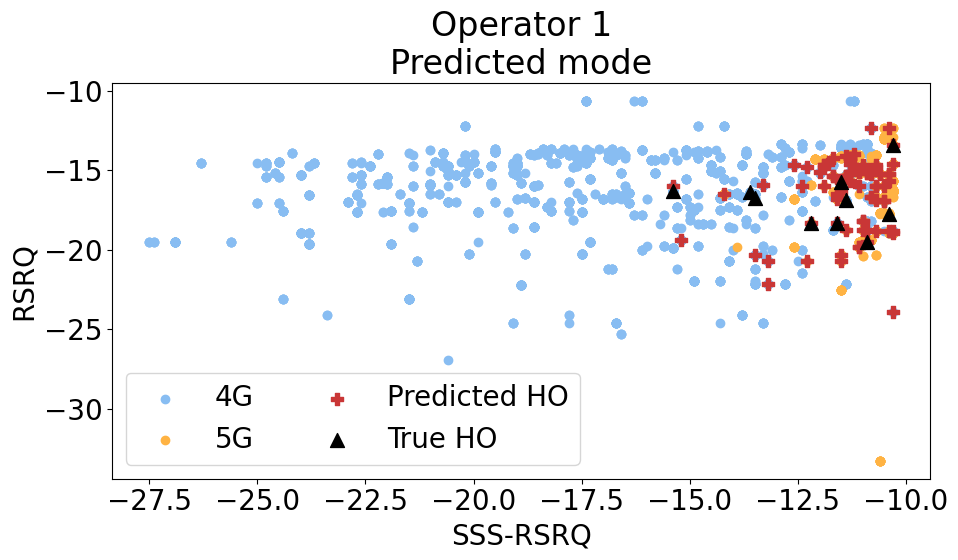

In [253]:
fig, ax = plt.subplots(figsize=(10, 6))
g4 = ax.scatter([x[1] for x in rsrq_pred_4G], [x[0] for x in rsrq_pred_4G], color=rsrp_colors[2], label='4G')
g5 = ax.scatter([x[1] for x in rsrq_pred_5G], [x[0] for x in rsrq_pred_5G], color=rsrq_colors[3], label='5G')
ho_pred = ax.scatter([x[0] for x in rsrq_pred_5g_ho], [x[1] for x in rsrq_pred_5g_ho], marker='P', color=mode_colors[1], s=80, label='Predicted HO')
ax.scatter([x[0] for x in rsrq_pred_4g_ho], [x[1] for x in rsrq_pred_4g_ho], marker='P', color=mode_colors[1], s=80, label='Predicted HO')
ho_true = ax.scatter(sss_rsrq_ho_to_5g, rsrq_ho_to_5g, marker='^', color='black', label='True HO', s=100)
ax.scatter(sss_rsrq_ho_to_4g, rsrq_ho_to_4g, marker='^', color='black', label='True HO', s=100)
plt.title(f'{operator}\nPredicted mode')
plt.xlabel('SSS-RSRQ')
plt.ylabel('RSRQ')
plt.legend(handles=[g4, g5, ho_pred, ho_true], ncols = 2)
plt.tight_layout()
plt.show()
fig.savefig(r'../latex/plots/thresholds/op1_rsrq_predicted_mode_with_ho.pdf')